In [4]:
import numpy as np
import matplotlib.pyplot as plt
loaded_data = np.load('E_field_data_combined_extended.npz' , allow_pickle=True)
print(loaded_data)
E_data_combined = loaded_data['data']
print(type(E_data_combined))  # To check the type of the loaded data
print(E_data_combined.shape)

<class 'numpy.ndarray'>
(9256, 5)


Normalized Training Set X Shape: (6942, 4) X dtype: float32
Normalized Training Set y Shape: (6942, 101, 181) y dtype: float32
Normalized Validation Set X Shape: (1388, 4) X dtype: float32
Normalized Validation Set y Shape: (1388, 101, 181) y dtype: float32
Normalized Test Set X Shape: (926, 4) X dtype: float32
Normalized Test Set y Shape: (926, 101, 181) y dtype: float32
(18281,)
(101, 181)


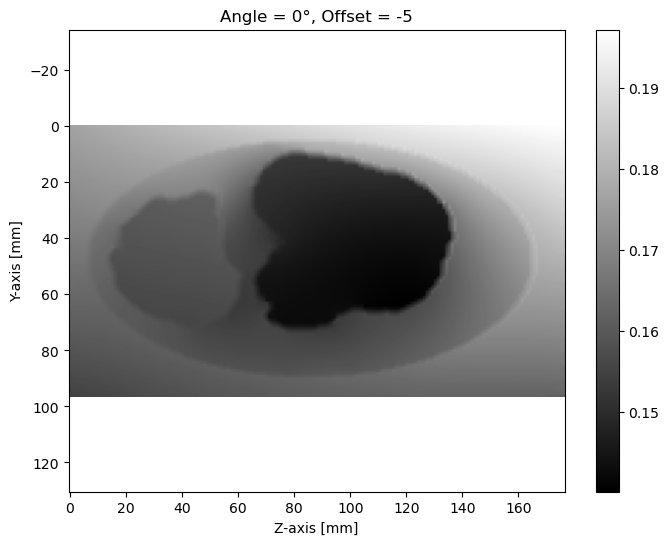

In [ ]:
import numpy as np

# Assuming 'data' is loaded and contains the dataset under the key "data"
E_data_combined = loaded_data["data"]

# Split features (first four columns) and matrices (last column)
conditions = E_data_combined[:, :-1].astype(np.float32)  # Convert feature data to float32
matrices = np.array([np.array(matrix, dtype=np.float32) for matrix[: ,] in E_data_combined[:, -1]])  # Convert matrices
# Normalize conditions
# conditions_min = conditions.min(axis=0)
# conditions_max = conditions.max(axis=0)
# X_normalized = (conditions - conditions_min) / (conditions_max - conditions_min)
X_normalized = conditions
# Randomly shuffle the data to avoid overfitting
num_samples = X_normalized.shape[0]
indices = np.random.permutation(num_samples)  # Shuffle the indices
X_normalized_shuffled = X_normalized[indices]
y_normalized_shuffled = matrices[indices]

# Calculate indices for training, validation, and test splits
train_size = int(0.75 * num_samples)
val_size = int(0.15 * num_samples)
test_size = num_samples - train_size - val_size  # Ensure all data is used

# Split the shuffled data into training, validation, and test sets
X_train_1, y_train_1 = X_normalized_shuffled[:train_size], y_normalized_shuffled[:train_size]
X_val_1, y_val_1 = X_normalized_shuffled[train_size:train_size + val_size], y_normalized_shuffled[train_size:train_size + val_size]
X_test_1, y_test_1 = X_normalized_shuffled[train_size + val_size:], y_normalized_shuffled[train_size + val_size:]

# Print detailed information about all normalized and split data sets
print("Normalized Training Set X Shape:", X_train_1.shape, "X dtype:", X_train_1.dtype)
print("Normalized Training Set y Shape:", y_train_1.shape, "y dtype:", y_train_1.dtype)
print("Normalized Validation Set X Shape:", X_val_1.shape, "X dtype:", X_val_1.dtype)
print("Normalized Validation Set y Shape:", y_val_1.shape, "y dtype:", y_val_1.dtype)
print("Normalized Test Set X Shape:", X_test_1.shape, "X dtype:", X_test_1.dtype)
print("Normalized Test Set y Shape:", y_test_1.shape, "y dtype:", y_test_1.dtype)


# Check and reshape y_test_1 for visualization
a_check = y_test_1[0].flatten()
print(a_check.shape)
a_check = a_check.reshape(101, 181)
print(a_check.shape)

# Define slicing parameters for plotting
a = slice(2, 179)  # Adjust for Y-axis (selects rows 2 to 178)
b = slice(2, 99)   # Adjust for Z-axis (selects rows 2 to 98)

# Assuming you want to plot only the first image (index 0)
selected_index = 89
angle, offset, direction, _, Ex_data = E_data_combined[selected_index]

plt.figure(figsize=(8, 6))
img = plt.imshow(a_check[b, a], cmap='gray')  # Visualize only the relevant slice of Ex_data

# Set titles and labels
plt.title(f'Angle = {angle}°, Offset = {offset}')
plt.xlabel('Z-axis [mm]')
plt.ylabel('Y-axis [mm]')
plt.axis('equal')  # Maintain equal aspect ratio for better visualization
plt.colorbar(img)  # Add a color bar for scale

# Show the single image
plt.show()


model is overfitting , so trying with some learning rate 

Now , we are update the code and use the the check point and droupout and earily stopping  

plot the best_model.h5 

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# Define the model with L2 regularization and Dropout
model = Sequential([
    Dense(4, activation='relu', input_shape=(X_train_1.shape[1],), kernel_regularizer=l2(0.001)),  # Input layer with L2 regularization
    Dropout(0.2),  # Dropout to prevent overfitting
    Dense(2**5, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(2**7, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(2**9, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(2**11, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(2**13, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(18281, activation='linear')  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(), loss='mse', metrics=['accuracy'])

# Create callbacks for early stopping and model checkpoints
checkpoint = ModelCheckpoint('best_model_linear.h5', monitor='val_loss', save_best_only=True, verbose=1, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Print model summary
model.summary()

# Assuming X_train, y_train_flat, X_val, y_val_flat are defined and prepared
y_train_flat = np.array([y.reshape(-1) for y in y_train_1])
y_val_flat = np.array([y.reshape(-1) for y in y_val_1])

# Train the model with the callbacks
history = model.fit(X_train_1, y_train_flat,
                    validation_data=(X_val_1, y_val_flat),
                    epochs=100, batch_size=16, verbose=1,
                    callbacks=[checkpoint, early_stopping])

# Function to plot training history
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Plotting the training history
plot_history(history)


2024-11-20 13:30:04.414958: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-11-20 13:30:05.216078: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-11-20 13:30:05.216609: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-11-20 13:30:05.228791: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: NVIDIA L40S computeCapability: 8.9
coreClock: 2.52GHz coreCount: 142 deviceMemorySize: 47.40GiB deviceMemoryBandwidth: 804.75GiB/s
2024-11-20 13:30:05.228806: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-11-20 13:30:05.229840: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-11-2

: 

In [7]:
from tensorflow.keras.models import load_model
model = load_model('best_model_linear.h5')

model.summary()
y_pred_best_model = model.predict(X_test_1)

# Reshape y_test for comparison
y_test_flat = np.array([y.reshape(-1) for y in y_test_1])

# Calculate the mean squared error on the test set
from sklearn.metrics import mean_absolute_error
test_mse = mean_absolute_error(y_test_flat, y_pred_best_model)
print("Test MSE:", test_mse)

from sklearn.metrics import r2_score
test_r2 = r2_score(y_test_flat, y_pred_best_model)
print("Test R^2 Score:", test_r2)
# for i in range(5):
#     print(f"Sample {i} Prediction vs Actual:")
#     print("Predicted:", y_pred_best_model[i][:10])
#     print("Actual:", y_test_flat[i][:10]) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                160       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4224      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               6

2024-11-20 13:32:50.226342: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-11-20 13:32:50.246706: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2999950000 Hz
2024-11-20 13:32:50.305932: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Test MSE: 0.18791524
Test R^2 Score: -0.052814657294360384


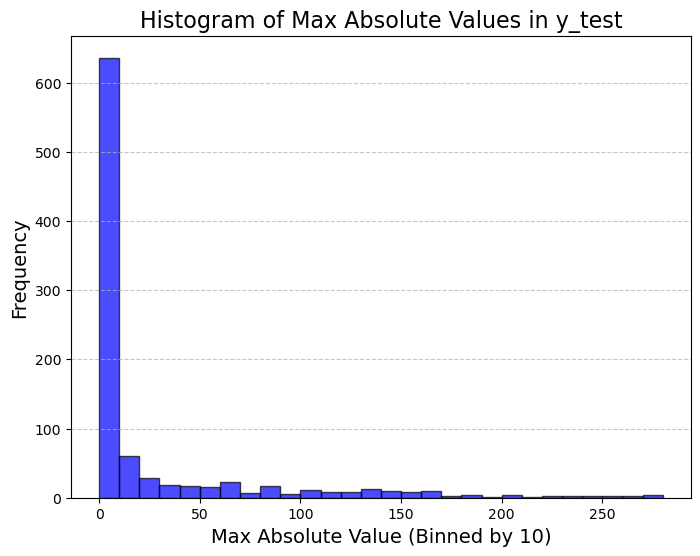

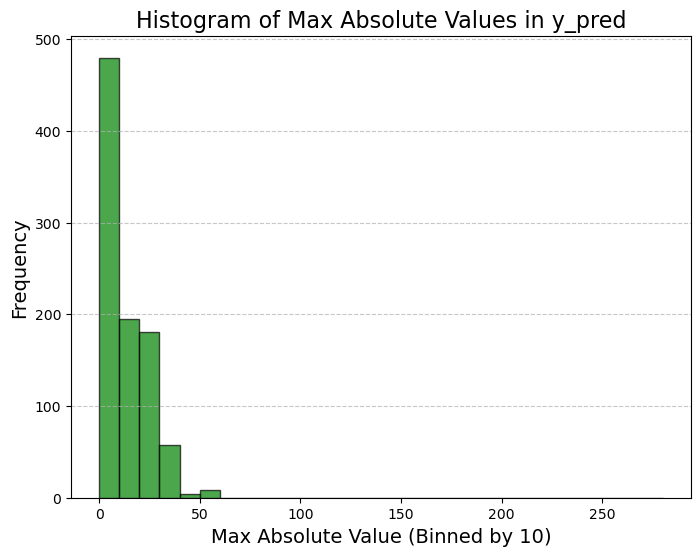

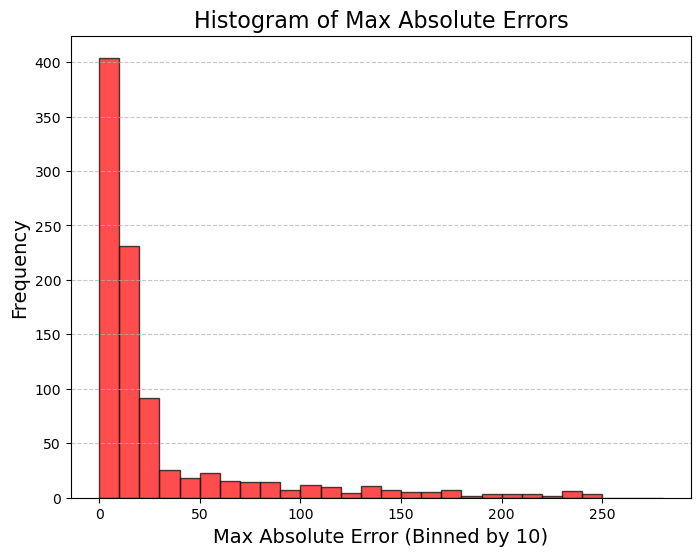

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

from tensorflow.keras.models import load_model
model = load_model('best_model_linear.h5')
y_pred_best_model = model.predict(X_test_1)

y_pred_reshaped = y_pred_best_model.reshape(926, 101, 181)
y_test_abs = np.abs(y_test_1)
max_y_test = np.max(y_test_abs, axis=(1, 2))
y_pred_abs = np.abs(y_pred_reshaped)
max_y_pred = np.max(y_pred_abs, axis=(1, 2))
abs_error = np.abs(y_test_1 - y_pred_reshaped)
max_error = np.max(abs_error, axis=(1, 2))
y_test_flat = y_test_1.reshape(926, -1)
test_mse = mean_absolute_error(y_test_flat, y_pred_best_model)
test_r2 = r2_score(y_test_flat, y_pred_best_model)
print("Test MSE:", test_mse)
print("Test R^2 Score:", test_r2)
bin_edges = np.arange(0, max(max(max_y_test), max(max_y_pred), max(max_error)) + 10, 10)
plt.figure(figsize=(8, 6))
plt.hist(max_y_test, bins=bin_edges, edgecolor='black', alpha=0.7, color='blue')
plt.title('Histogram of Max Absolute Values in y_test', fontsize=16)
plt.xlabel('Max Absolute Value (Binned by 10)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot 2: Predicted (y_pred)
plt.figure(figsize=(8, 6))
plt.hist(max_y_pred, bins=bin_edges, edgecolor='black', alpha=0.7, color='green')
plt.title('Histogram of Max Absolute Values in y_pred', fontsize=16)
plt.xlabel('Max Absolute Value (Binned by 10)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot 3: MSE Error
plt.figure(figsize=(8, 6))
plt.hist(max_error, bins=bin_edges, edgecolor='black', alpha=0.7, color='red')
plt.title('Histogram of Max Absolute Errors', fontsize=16)
plt.xlabel('Max Absolute Error (Binned by 10)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


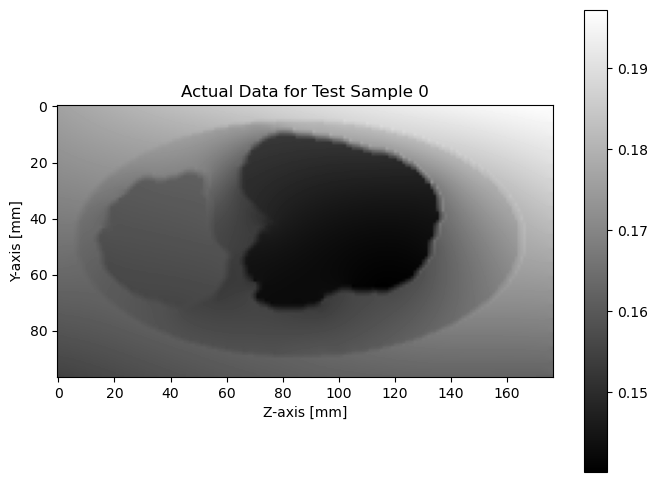

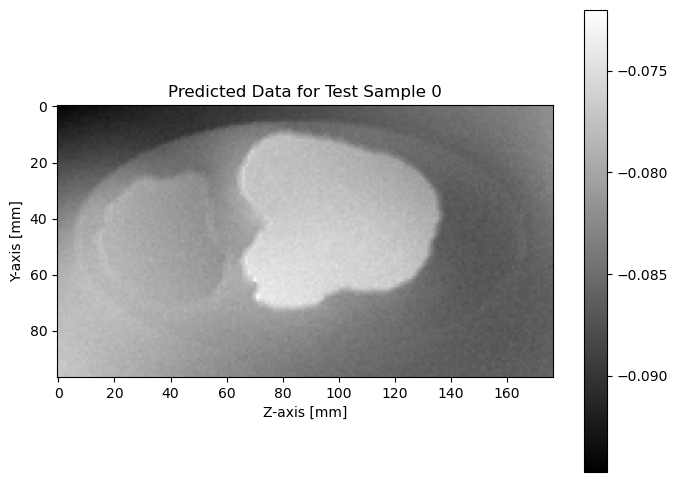

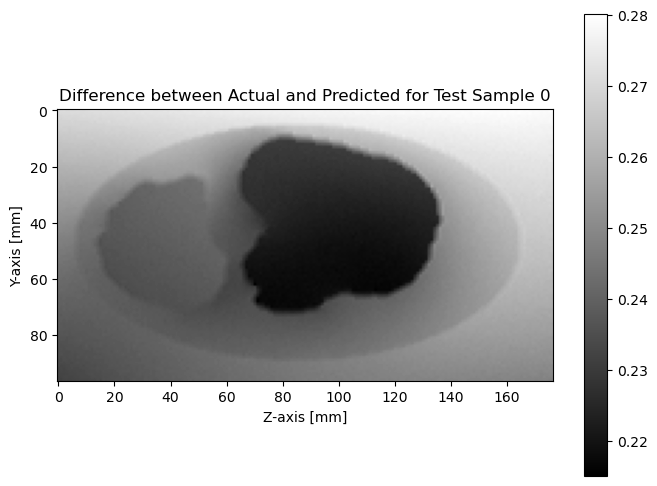

Sample 0 Prediction vs Actual (Flattened):
Predicted (First 10 values): [-0.09473065 -0.09497173 -0.09476122 -0.09446809 -0.09443581 -0.09471039
 -0.09475774 -0.09428936 -0.09401808 -0.09388401]
Actual (First 10 values): [0.17640002 0.17654546 0.17676729 0.17698441 0.17707615 0.1772016
 0.17736979 0.17759681 0.1778118  0.17789993]




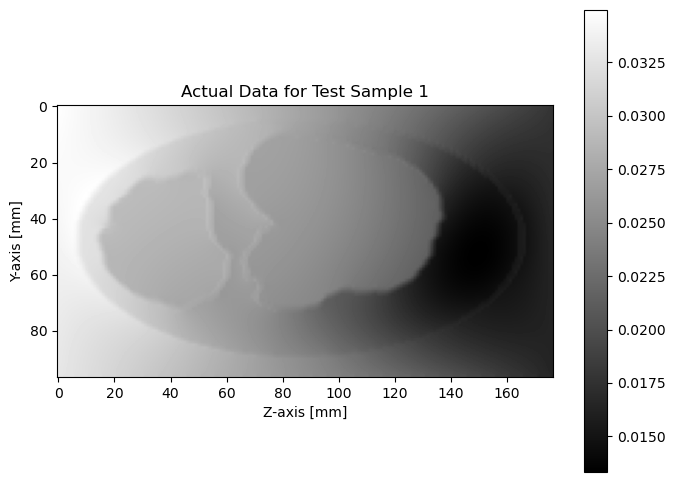

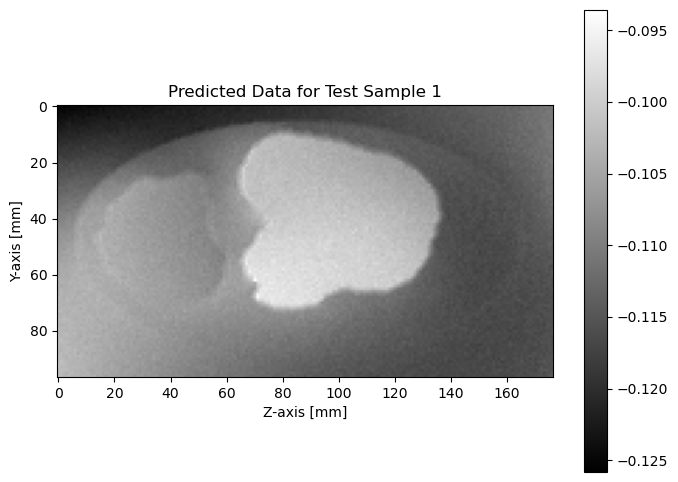

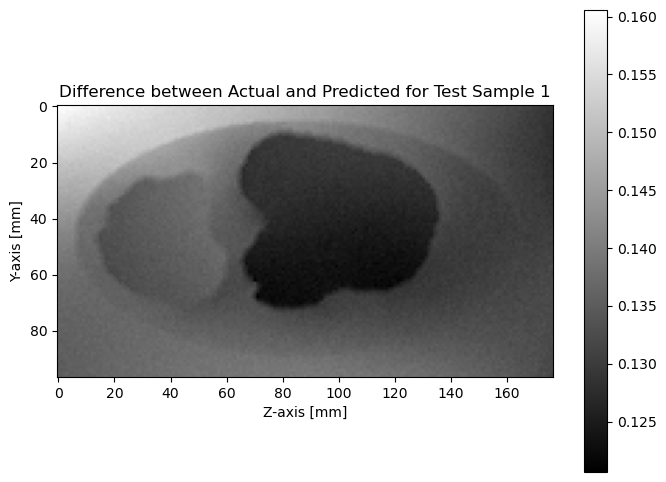

Sample 1 Prediction vs Actual (Flattened):
Predicted (First 10 values): [-0.12590125 -0.12601869 -0.12568462 -0.12587123 -0.12601103 -0.12609717
 -0.12625715 -0.12589382 -0.1252778  -0.12457788]
Actual (First 10 values): [0.03510192 0.03501311 0.03490319 0.0347955  0.03474804 0.03468767
 0.03460121 0.03448797 0.03438028 0.03433254]




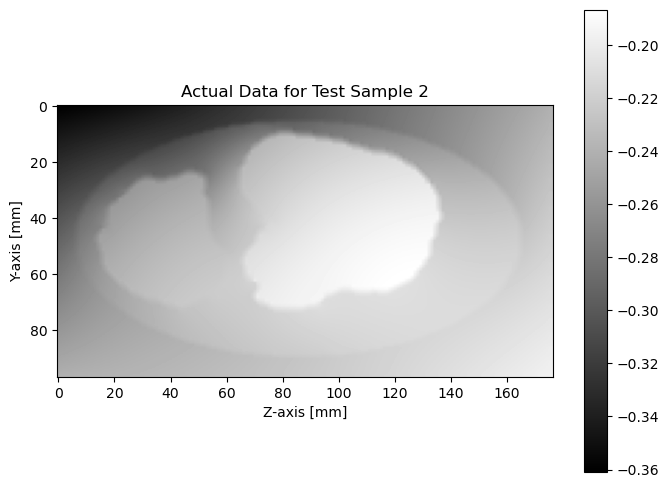

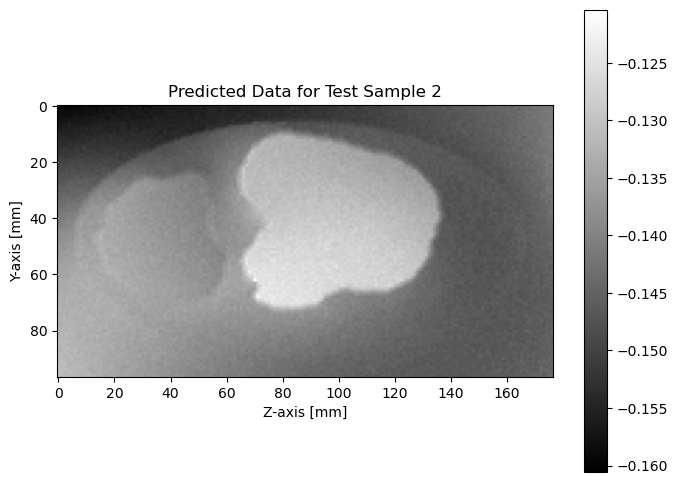

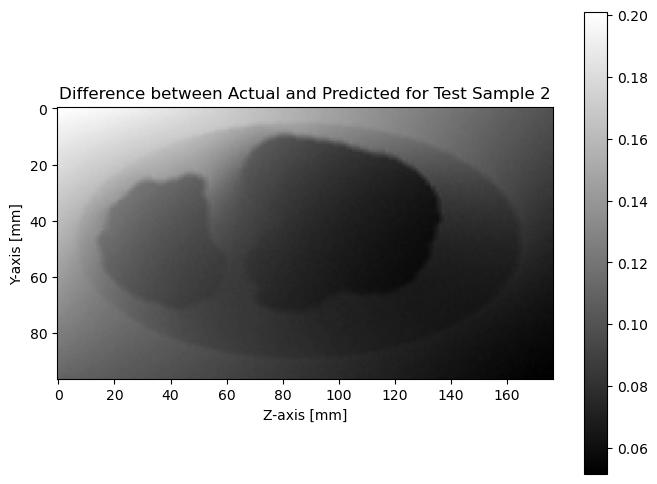

Sample 2 Prediction vs Actual (Flattened):
Predicted (First 10 values): [-0.16020538 -0.16050495 -0.16039272 -0.16017234 -0.16079447 -0.16050266
 -0.16054246 -0.16042015 -0.15992165 -0.15940014]
Actual (First 10 values): [-0.3648282  -0.3642775  -0.36377126 -0.3633094  -0.36310512 -0.36283866
 -0.36245674 -0.36196825 -0.36147976 -0.36126658]




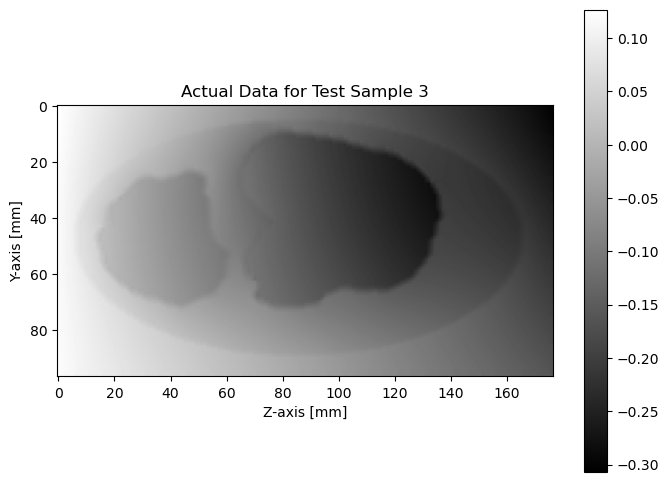

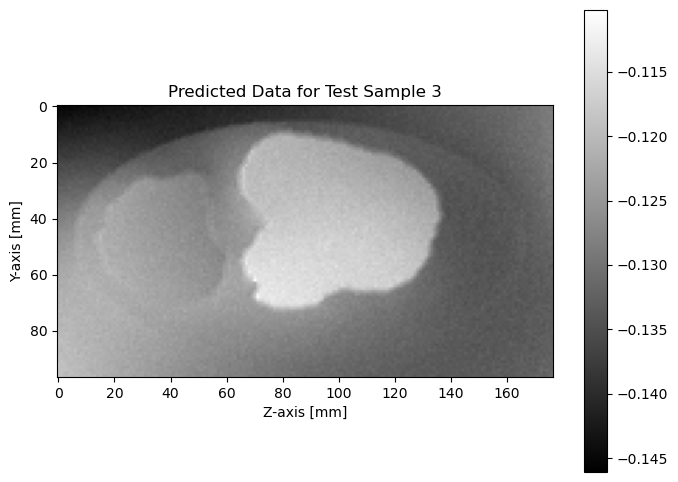

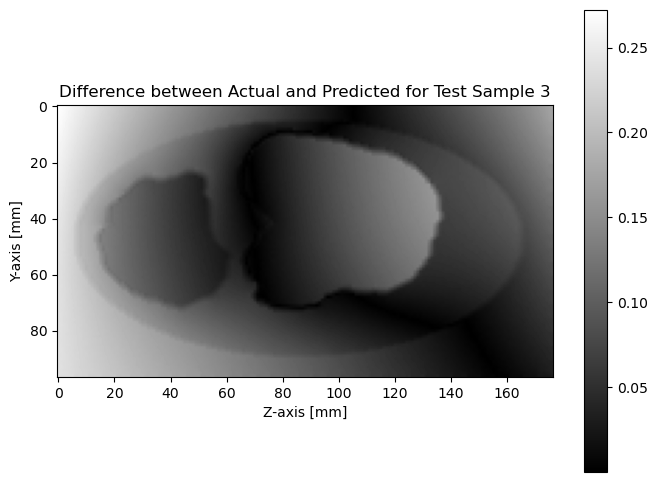

Sample 3 Prediction vs Actual (Flattened):
Predicted (First 10 values): [-0.14569373 -0.14604408 -0.14595233 -0.14561185 -0.14611152 -0.14599596
 -0.14600526 -0.14582548 -0.145312   -0.14495549]
Actual (First 10 values): [0.13378632 0.13134383 0.12763235 0.12410074 0.12260415 0.12060575
 0.11780799 0.11416979 0.11070923 0.10919266]




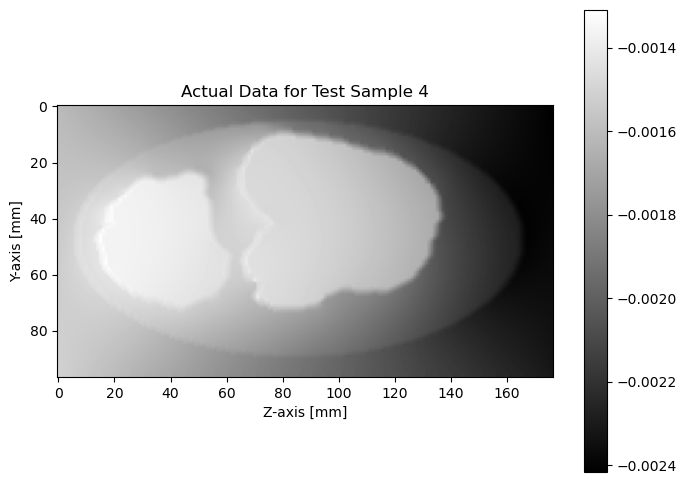

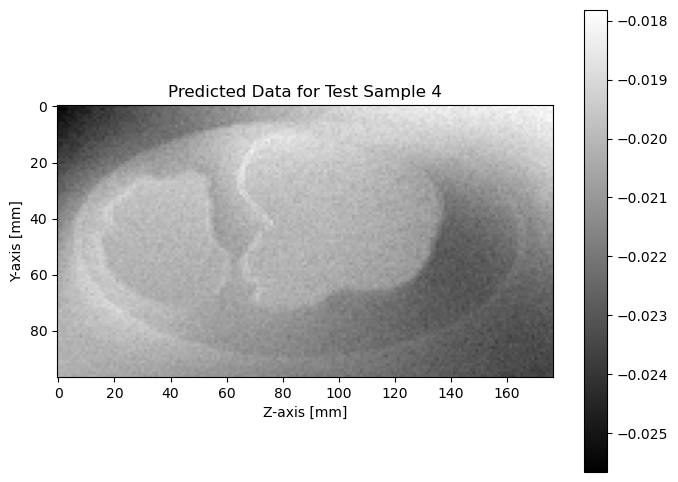

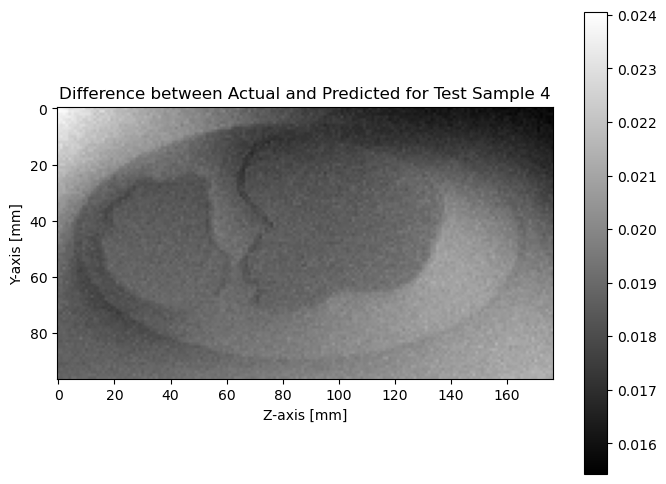

Sample 4 Prediction vs Actual (Flattened):
Predicted (First 10 values): [-0.02587248 -0.02571041 -0.02560333 -0.02564217 -0.02536434 -0.02544964
 -0.02555704 -0.02492242 -0.02497291 -0.02456668]
Actual (First 10 values): [-0.00159804 -0.00160229 -0.00160903 -0.00161544 -0.00161818 -0.00162188
 -0.00162699 -0.00163361 -0.00164006 -0.00164278]




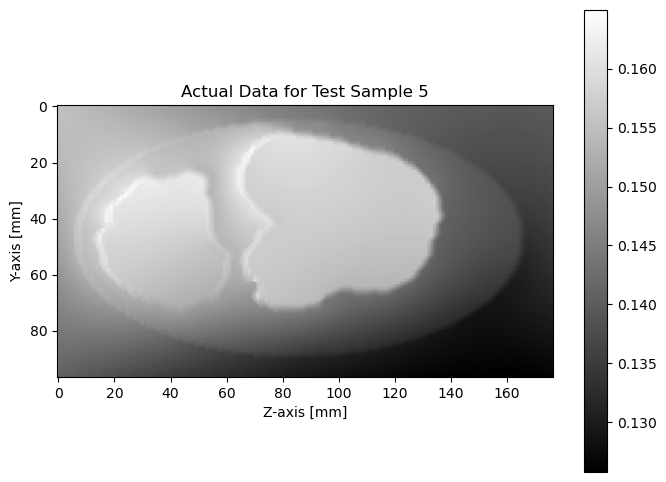

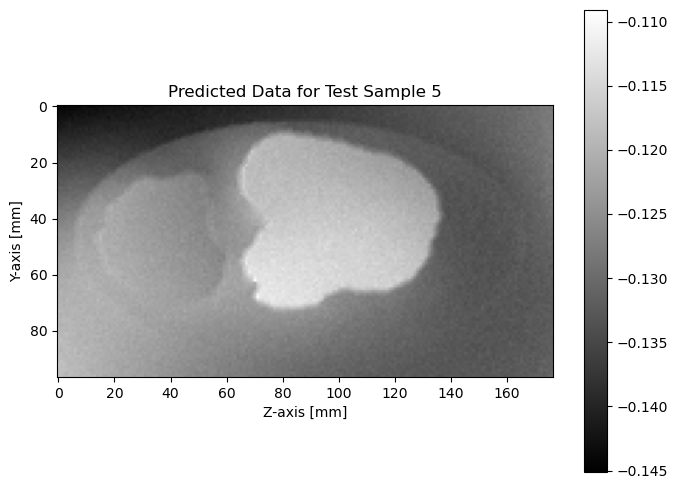

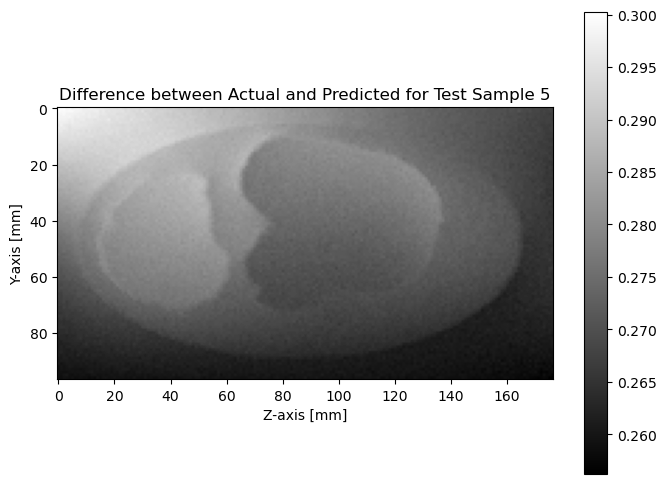

Sample 5 Prediction vs Actual (Flattened):
Predicted (First 10 values): [-0.14480586 -0.14510685 -0.14498846 -0.14474778 -0.14520776 -0.14507774
 -0.14512633 -0.1449249  -0.1443968  -0.14396666]
Actual (First 10 values): [0.15581314 0.15565328 0.15545788 0.15527137 0.1552003  0.15508485
 0.15495162 0.15475622 0.1545697  0.15448754]




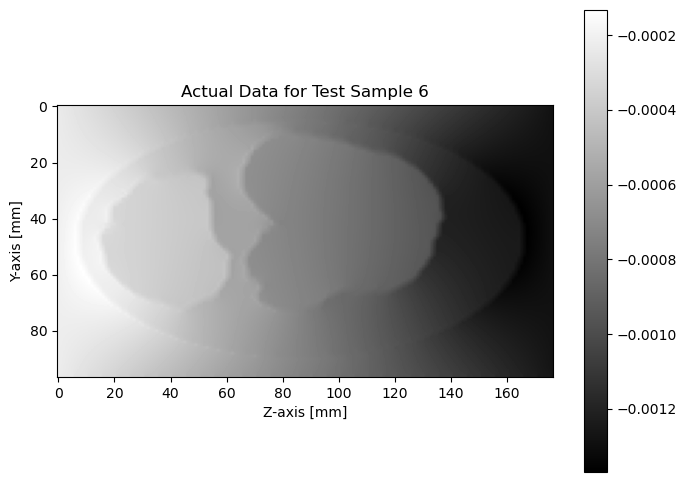

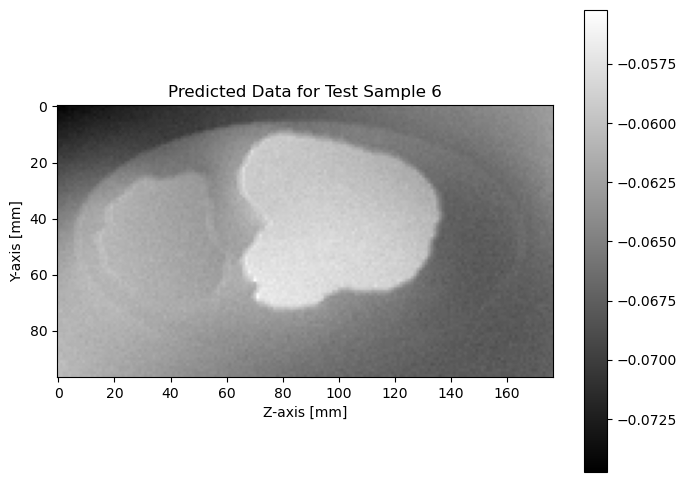

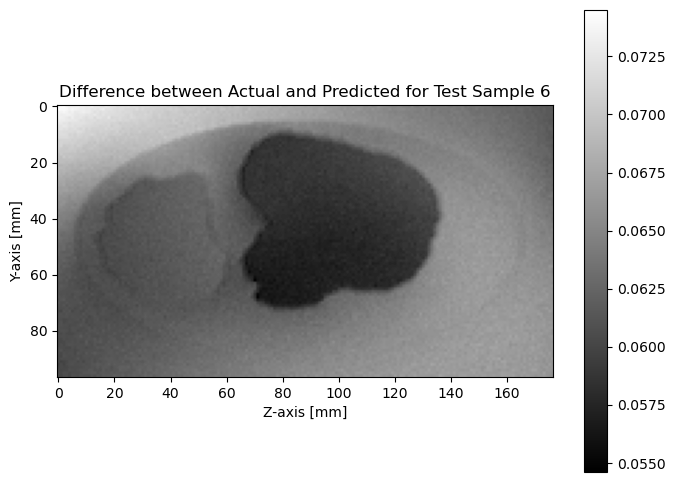

Sample 6 Prediction vs Actual (Flattened):
Predicted (First 10 values): [-0.07489917 -0.074893   -0.07482201 -0.07462126 -0.07439166 -0.07469144
 -0.07488908 -0.07399425 -0.07397348 -0.07370039]
Actual (First 10 values): [-0.0002201  -0.00022527 -0.00023353 -0.00024154 -0.0002448  -0.00024931
 -0.00025558 -0.00026385 -0.00027187 -0.0002752 ]




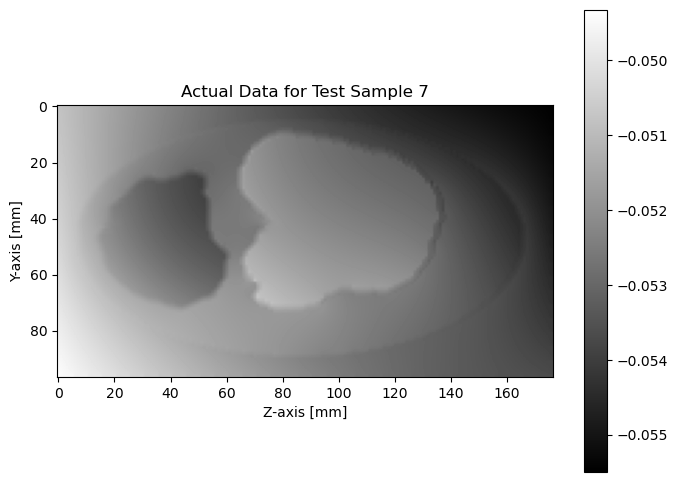

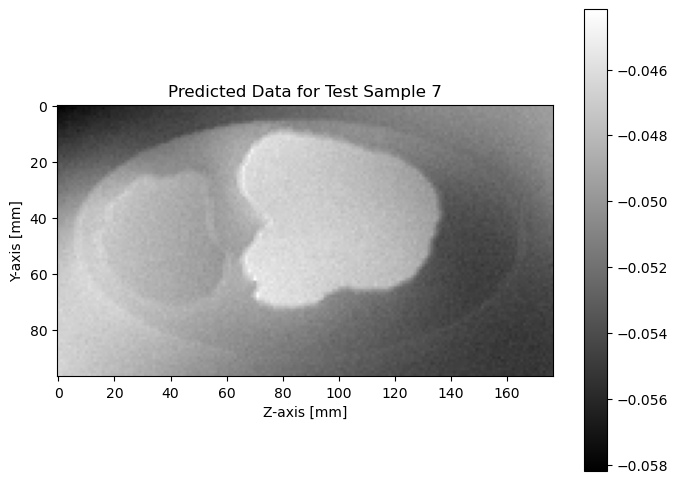

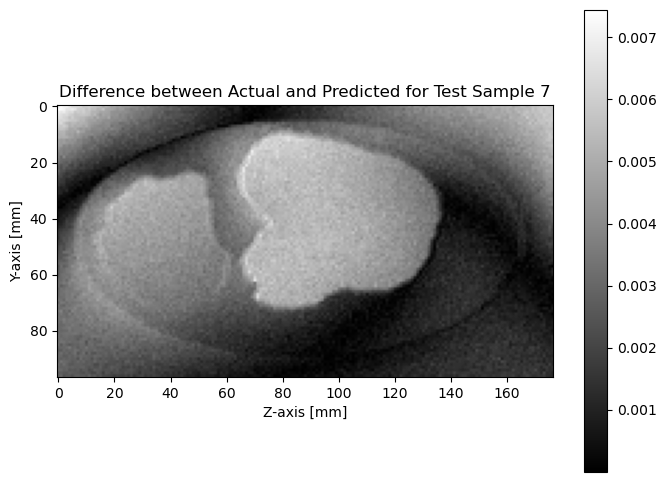

Sample 7 Prediction vs Actual (Flattened):
Predicted (First 10 values): [-0.05860292 -0.05858353 -0.05826582 -0.05820376 -0.05787137 -0.05845901
 -0.05835133 -0.05788749 -0.05748545 -0.05724316]
Actual (First 10 values): [-0.05070278 -0.0507383  -0.0507916  -0.050846   -0.05086792 -0.05089568
 -0.05093925 -0.05099699 -0.05105028 -0.05107193]




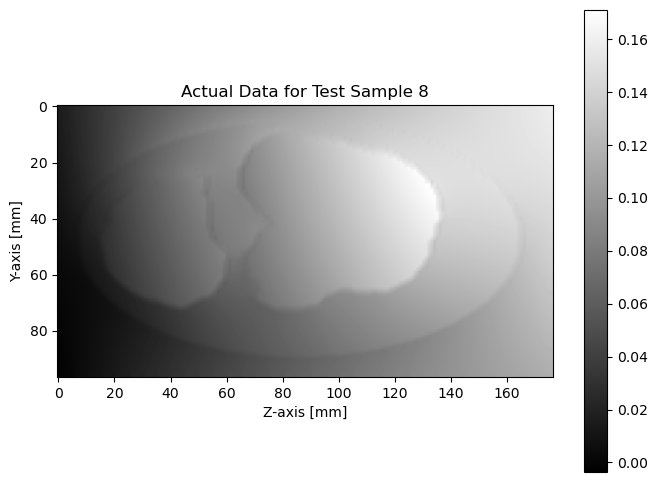

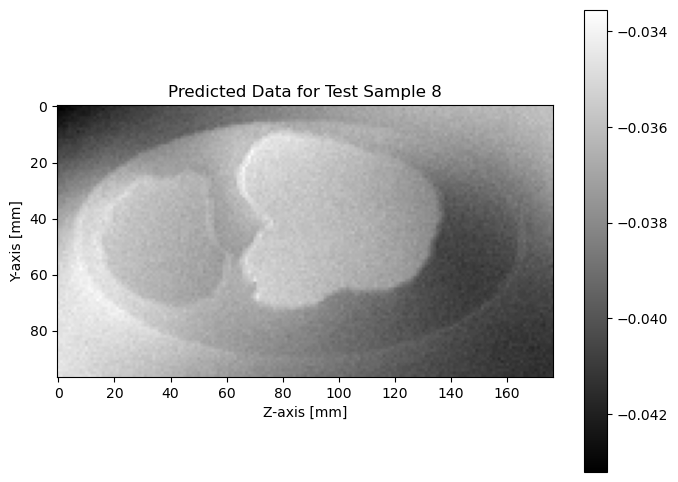

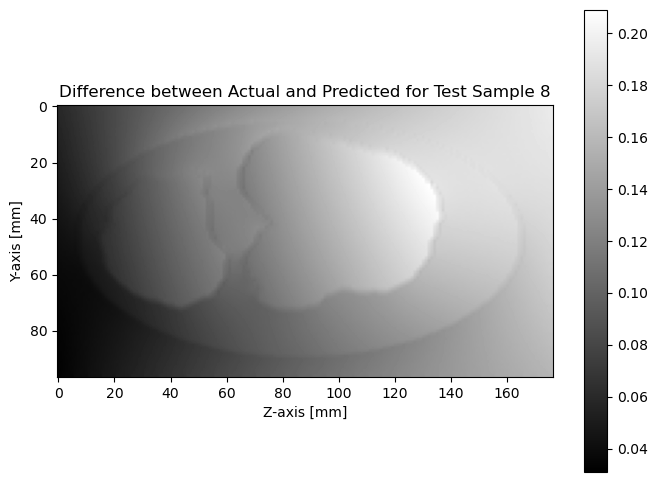

Sample 8 Prediction vs Actual (Flattened):
Predicted (First 10 values): [-0.04351532 -0.04356855 -0.04318617 -0.04317763 -0.04293658 -0.04333934
 -0.04312012 -0.04299868 -0.04254418 -0.04230328]
Actual (First 10 values): [0.0125322  0.01347367 0.0152367  0.01689315 0.01761258 0.01858513
 0.01992184 0.02167377 0.02332579 0.02404299]




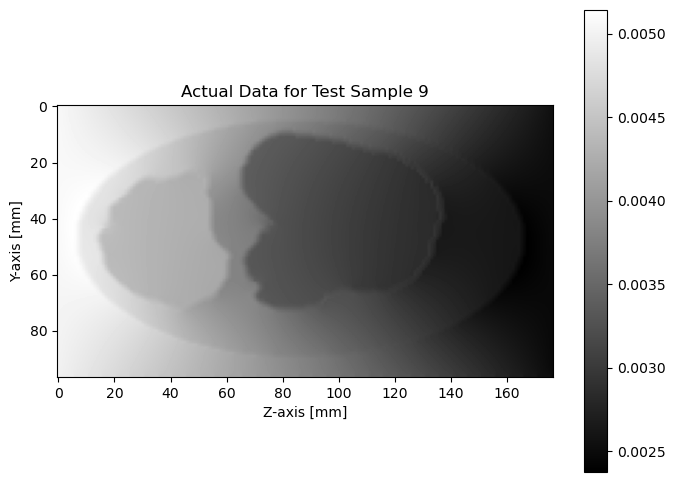

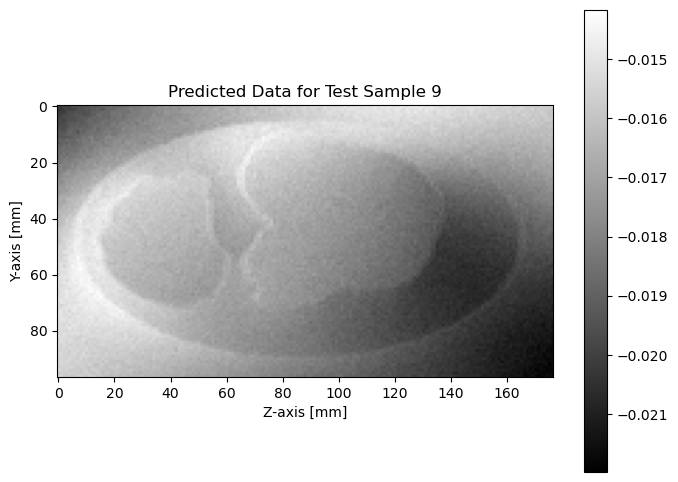

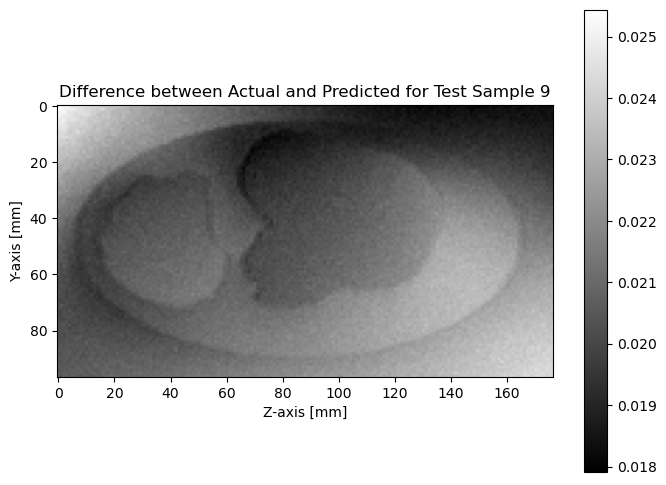

Sample 9 Prediction vs Actual (Flattened):
Predicted (First 10 values): [-0.02064822 -0.02057557 -0.02015081 -0.02039312 -0.01997837 -0.02054212
 -0.02022659 -0.02001599 -0.01964373 -0.01952593]
Actual (First 10 values): [0.0050866  0.00507426 0.00505672 0.00504    0.00503292 0.00502317
 0.00500985 0.00499226 0.00497567 0.0049686 ]




In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Reshape y_test and y_pred for comparison
y_test_flat = np.array([y.reshape(-1) for y in y_test_1])
y_pred_flat = np.array([y.reshape(-1) for y in y_pred_best_model])
indices_to_plot = range(10)

# Define slicing parameters for plotting (same as before)
a = slice(2, 179)  # Y-axis (rows)
b = slice(2, 99)   # Z-axis (rows)

# Plotting the first 5 samples
for selected_index in indices_to_plot:
    # Reshape the selected test and predicted data back to (101, 181)
    y_test_selected = y_test_flat[selected_index].reshape(101, 181)
    y_pred_selected = y_pred_flat[selected_index].reshape(101, 181)
    y_pred_selected*0.1
    # Plot actual data
    plt.figure(figsize=(8, 6))
    img_actual = plt.imshow(y_test_selected[b, a], cmap='gray')  # Plot actual data slice
    plt.title(f'Actual Data for Test Sample {selected_index}')
    plt.xlabel('Z-axis [mm]')
    plt.ylabel('Y-axis [mm]')
    plt.colorbar(img_actual)  # Add a color bar for scale
    plt.show()

    # Plot predicted data
    plt.figure(figsize=(8, 6))
    img_pred = plt.imshow(y_pred_selected[b, a], cmap='gray')  # Plot predicted data slice
    plt.title(f'Predicted Data for Test Sample {selected_index}')
    plt.xlabel('Z-axis [mm]')
    plt.ylabel('Y-axis [mm]')
    plt.colorbar(img_pred)  # Add a color bar for scale
    plt.show()

    # Plot difference between actual and predicted
    plt.figure(figsize=(8, 6))
    img_diff = plt.imshow(np.abs(y_test_selected[b, a] - y_pred_selected[b, a]), cmap='gray')  # Plot difference
    plt.title(f'Difference between Actual and Predicted for Test Sample {selected_index}')
    plt.xlabel('Z-axis [mm]')
    plt.ylabel('Y-axis [mm]')
    plt.colorbar(img_diff)  # Add a color bar for scale
    plt.show()

    # Print the actual vs predicted values (flattened for comparison)
    print(f"Sample {selected_index} Prediction vs Actual (Flattened):")
    print("Predicted (First 10 values):", y_pred_flat[selected_index][:10])
    print("Actual (First 10 values):", y_test_flat[selected_index][:10])
    print("\n")
